# Data analysis
This notebook contains the analysis of the merged dataset resulting from the sequences and metadata datasets provided by the RKI andthe location dataset provided by the GODI. The dataset was investigated on in terms of mutation dynamics as well as seasonal and geographical impacts.

In [1]:
!pip install ../../gentrain/.

Processing /Users/benkraling/code/thesis/gentrain
  Preparing metadata (setup.py) ... done
  Created wheel for gentrain: filename=gentrain-0.1.2-py3-none-any.whl size=26911 sha256=b14e529480250478e79424cb18d0ae3383254ae9751c51ff4d636db55b8d783c
  Stored in directory: /private/var/folders/2h/923cq6912sqb0snfvqqfdnmm0000gn/T/pip-ephem-wheel-cache-fqlvembr/wheels/cf/e4/57/91c03db2e8c043adeefe35dd0969d3049f61ae0218be0acc9f
Successfully built gentrain
  Attempting uninstall: gentrain
    Found existing installation: gentrain 0.1.2
    Uninstalling gentrain-0.1.2:
      Successfully uninstalled gentrain-0.1.2


In [2]:
import plotly.io as pio
pio.renderers.default = "png"

In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re

pd.set_option("display.max_columns", None)

# Data Analysis
This notebook addresses the data analysis process of a merged dataset resulting from SARS-CoV-2 sequences from germany published by the RKI and geolocation dataset for germany published by the "Open Knowledge Foundation Deutschland".

**SARS-CoV-2-Sequenzdaten aus Deutschland**<br/>
https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland

**Geolocation Dataset Germany**<br/>
https://2015.index.okfn.org/place/germany/postcodes/

In [4]:
isolates_df = pd.read_csv("../../data/rki_sars_cov_2.csv", delimiter=";", low_memory=False)
isolates_df.loc[:, "igs_id"] = isolates_df["seqName"].str.split(" ").str[0]
isolates_df = isolates_df.drop("seqName", axis=1)
isolates_df = isolates_df[
    ["igs_id", "substitutions", "insertions", "deletions", "missing", "nonACGTNs", "totalSubstitutions",
     "totalInsertions", "totalDeletions", "totalMissing", "totalNonACGTNs", "alignmentScore", "alignmentStart",
     "alignmentEnd", "coverage", "clade", "Nextclade_pango", "clade_who", "qc.overallScore"]]

In [5]:
metadata_df = pd.read_csv("../../data/metadata.tsv", delimiter="\t", index_col=0)

In [6]:
dataset_df = pd.merge(isolates_df, metadata_df, on="igs_id", how="outer")
igs_id_column = dataset_df.pop("igs_id")
dataset_df.insert(0, "igs_id", igs_id_column)

Retrieve month of sampling.

In [7]:
def retrieve_month_of_sampling(date):
    if type(date) != str:
        return None
    pattern = r"\d{4}-\d{2}"
    match = re.search(pattern, date)
    if match:
        return match.group()
dataset_df["month_of_sampling"] = dataset_df["date_of_sampling"].apply(lambda x: retrieve_month_of_sampling(x))

Retrieve geographic location information.

In [8]:
with open("../../data/DE_zip_codes.txt") as zip_codes_file:
    coords = {}
    cities = {}
    states = {}
    for line in zip_codes_file:
        values = line.split("\t")
        coords[values[1]] = (values[9], values[10])
        cities[values[1]] = values[7]
        states[values[1]] = values[3]

In [9]:
dataset_df.dropna(subset=["sequencing_lab.postal_code"], inplace=True)
dataset_df.dropna(subset=["prime_diagnostic_lab.postal_code"], inplace=True)

In [10]:
dataset_df["sequencing_lab.postal_code"] = dataset_df["sequencing_lab.postal_code"].apply(
    lambda x: str(f"0{int(x)}") if len(str(int(x))) == 4 else str(int(x)))
dataset_df["prime_diagnostic_lab.postal_code"] = dataset_df["prime_diagnostic_lab.postal_code"].apply(
    lambda x: str(f"0{int(x)}") if len(str(int(x))) == 4 else str(int(x)))
dataset_df["prime_diagnostic_lab.state"] = dataset_df["prime_diagnostic_lab.postal_code"].apply(lambda x: states[x] if x in states else None)
dataset_df["prime_diagnostic_lab.city"] = dataset_df["prime_diagnostic_lab.postal_code"].apply(lambda x: cities[x] if x in states else None)

In [11]:
columns = list(dataset_df)
columns.insert(columns.index("prime_diagnostic_lab.postal_code"), columns.pop(columns.index("prime_diagnostic_lab.state")))
columns.insert(columns.index("prime_diagnostic_lab.postal_code"), columns.pop(columns.index("prime_diagnostic_lab.city")))
dataset_df = dataset_df.loc[:, columns]
total_dataset_df = dataset_df

## Cases count per sampling month

In [12]:
sequence_count_per_sampling_month_df = dataset_df.groupby(["month_of_sampling"]).size().reset_index(name="count")

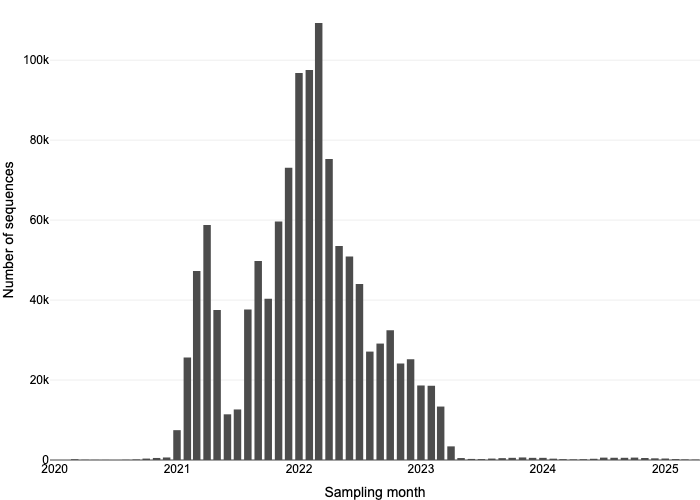

In [13]:
fig = px.bar(sequence_count_per_sampling_month_df, x="month_of_sampling", y="count", color_discrete_sequence=["#4c4c4c"], width=1000, height=600)
fig.update_layout(template="presentation", margin=dict(t=0, b=40, l=50, r=0), font=dict(
        family="Arial",
        size=12,
        color="black"
    ), xaxis_title="Sampling month",
    yaxis_title="Number of sequences")
fig.show()

In [14]:
len(dataset_df)

1192040

The dataset consists of 1.192.040 sequences, which were mainly sequences from January 2021 to April 2023. Besides this seasonal interval only a few sequences are available since at the beginning of the pandemic the sequencing infrastructure had to be set up first (before January 2021) and the availability of vaccines rapidly decreased the relevance of sequencing (after April 2023). Therefore months besides this interval are excluded for a consistent data availability thoughout this work.

In [15]:
dataset_df = dataset_df[(dataset_df["date_of_sampling"] >= "2021-01-01") & (dataset_df["date_of_sampling"] <= "2023-04-31")]

In [16]:
len(dataset_df)

1180708

In [17]:
sequence_count_per_sampling_month_df = dataset_df.groupby(["month_of_sampling"]).size().reset_index(name="count")

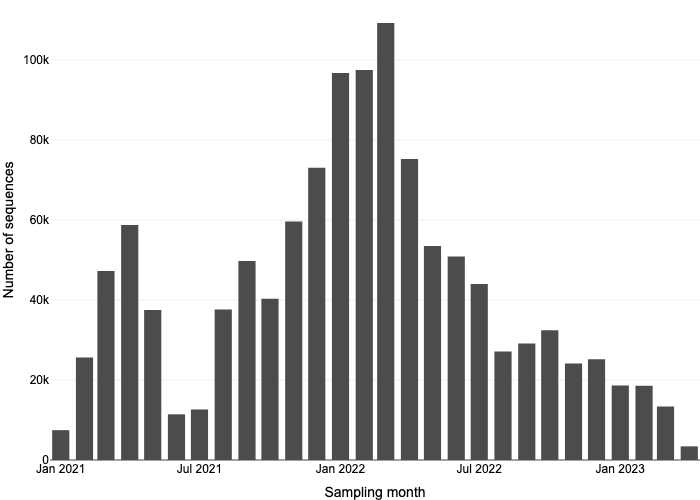

In [18]:
fig = px.bar(sequence_count_per_sampling_month_df, x="month_of_sampling", y="count", color_discrete_sequence=["#4c4c4c"], width=1000, height=600)
fig.update_layout(template="presentation", margin=dict(t=0, b=40, l=50, r=0), font=dict(
        family="Arial",
        size=12,
        color="black"
    ), xaxis_title="Sampling month",
    yaxis_title="Number of sequences")
fig.show()

### 1.180.708 sequences remain.

## Distribution of clades

In [19]:
clade_count_per_sampling_month_df = dataset_df.groupby(["month_of_sampling", "clade"]).size().reset_index(name="count").sort_values(by=["clade"])

In [20]:
clade_percentages = []
for index, row in clade_count_per_sampling_month_df.iterrows():
    monthly_sequences = sequence_count_per_sampling_month_df[sequence_count_per_sampling_month_df["month_of_sampling"] == row["month_of_sampling"]]["count"].values[0]
    clade_percentages.append(row["count"]/monthly_sequences)
clade_count_per_sampling_month_df["percentage"] = clade_percentages

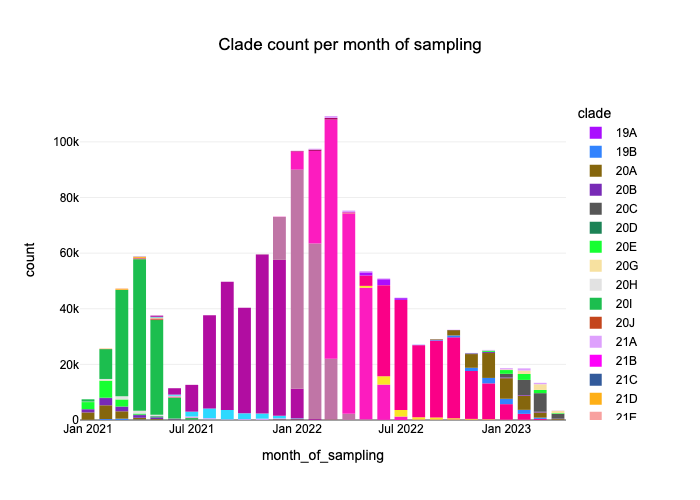

In [21]:
fig = px.bar(clade_count_per_sampling_month_df, x="month_of_sampling", y="count", color="clade", title="Clade count per month of sampling", color_discrete_sequence=px.colors.qualitative.Alphabet, width=1000, height=600)
fig.update_layout(template="presentation", font=dict(
        family="Arial",
        size=12,
        color="black"
    ))
fig.show()

It becomes evident that clades are dependent on seasonal periods. There are several prevalent clade (22B, 22E, 21K, 21L, ...)

## Distribution of WHO variants

In [22]:
pango_count_per_sampling_month_df = dataset_df.groupby(["month_of_sampling", "Nextclade_pango"]).size().reset_index(name="count").sort_values(by=["Nextclade_pango"])

In [23]:
pango_percentages = []
for index, row in pango_count_per_sampling_month_df.iterrows():
    monthly_sequences = sequence_count_per_sampling_month_df[sequence_count_per_sampling_month_df["month_of_sampling"] == row["month_of_sampling"]]["count"].values[0]
    pango_percentages.append(row["count"]/monthly_sequences)
pango_count_per_sampling_month_df["percentage"] = pango_percentages

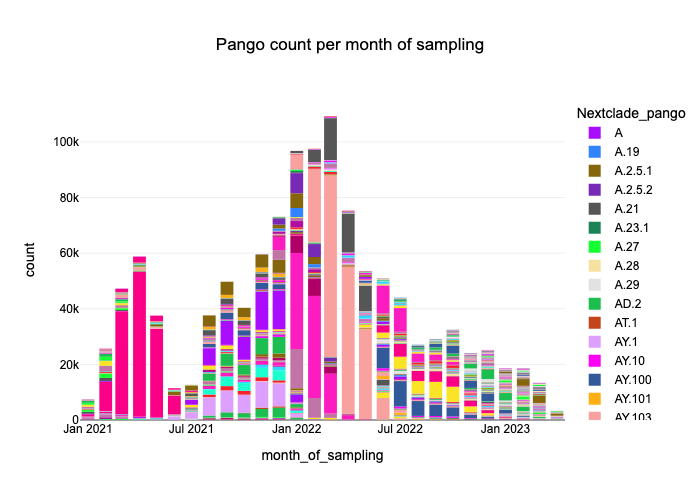

In [24]:
fig = px.bar(pango_count_per_sampling_month_df, x="month_of_sampling", y="count", color="Nextclade_pango", title="Pango count per month of sampling", color_discrete_sequence=px.colors.qualitative.Alphabet, width=1000, height=600)
fig.update_layout(template="presentation", font=dict(
        family="Arial",
        size=12,
        color="black"
    ))
fig.show()

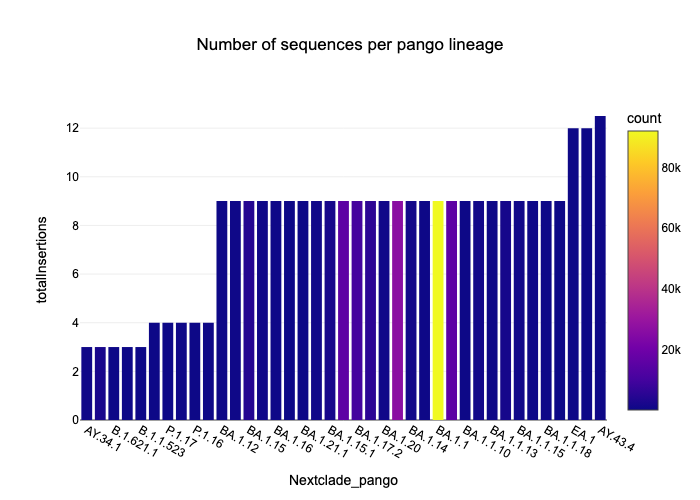

In [25]:
pango_mutations = dataset_df.groupby("Nextclade_pango", as_index=False).agg({"totalInsertions":"median"})
pango_mutations_counts = dataset_df.groupby("Nextclade_pango", as_index=False).size()
pango_mutations["count"] = pango_mutations_counts["size"]
pango_mutations = pango_mutations.sort_values(by=["totalInsertions"])
fig = px.bar(pango_mutations[(pango_mutations["totalInsertions"] > 1)&(pango_mutations["count"] > 100)], x="Nextclade_pango", y="totalInsertions", color="count", title="Number of sequences per pango lineage", width=1000, height=600)
fig.update_layout(template="presentation", font=dict(
        family="Arial",
        size=12,
        color="black"
    ))
fig.show()

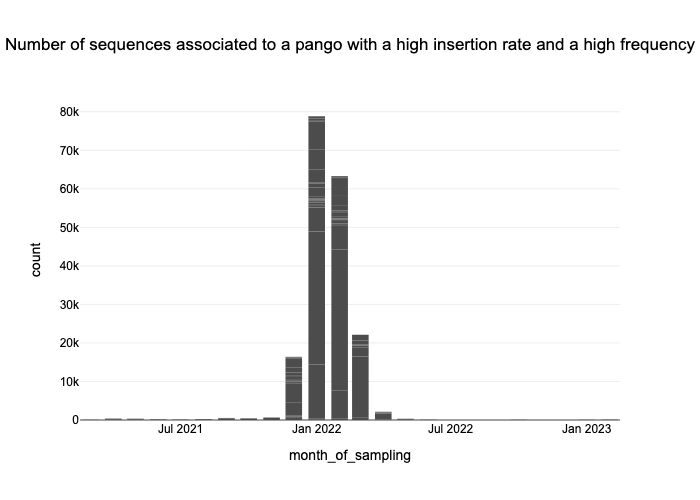

In [26]:
pango_mutations_per_month = dataset_df.groupby(["month_of_sampling", "Nextclade_pango"], as_index=False).agg({"totalInsertions":"median"})
pango_mutations_counts = dataset_df.groupby(["month_of_sampling", "Nextclade_pango"], as_index=False).size()
pango_mutations_per_month["count"] = pango_mutations_counts["size"]
fig = px.bar(pango_mutations_per_month[(pango_mutations_per_month["totalInsertions"] > 0)&(pango_mutations_per_month["count"] > 50)], x="month_of_sampling", y="count", color_discrete_sequence=["#4c4c4c"], title="Number of sequences associated to a pango with a high insertion rate and a high frequency", width=1000, height=600)
fig.update_layout(template="presentation", font=dict(
        family="Arial",
        size=12,
        color="black"
    ))
fig.show()

The figure shows the count of the occurences of insertions which have a very high median value of total occurences per sequence and a high representation through the dataset.

In [27]:
dataset_df["totalInsertions"].mean()

np.float64(2.7567477834882155)

In [28]:
variant_count_per_sampling_month_df = dataset_df.groupby(["month_of_sampling", "clade_who"], dropna=False).size().reset_index(name="count").sort_values(by=["clade_who"])

In [29]:
variant_count_per_sampling_month_df["clade_who"] = variant_count_per_sampling_month_df["clade_who"].fillna("Not determined")

In [30]:
dominant_variant_count_per_sampling_month_df = variant_count_per_sampling_month_df
dominant_variant_count_per_sampling_month_df["clade_who"] = variant_count_per_sampling_month_df["clade_who"].where(variant_count_per_sampling_month_df["clade_who"].isin(["Alpha", "Delta", "Omicron", "Not determined"]), "Other")

In [31]:
variant_percentages = []
for index, row in variant_count_per_sampling_month_df.iterrows():
    monthly_sequences = sequence_count_per_sampling_month_df[sequence_count_per_sampling_month_df["month_of_sampling"] == row["month_of_sampling"]]["count"].values[0]
    variant_percentages.append(row["count"]/monthly_sequences)
variant_count_per_sampling_month_df["percentage"] = variant_percentages

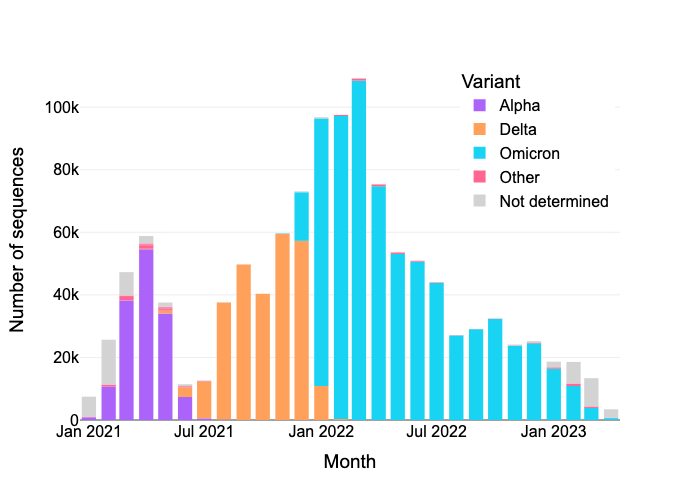

In [84]:
fig = px.bar(dominant_variant_count_per_sampling_month_df, x="month_of_sampling", y="count", color="clade_who", color_discrete_sequence=px.colors.qualitative.Plotly[3:7] + ["lightgrey"], width=1000, height=600, category_orders={"clade_who": ["Alpha", "Delta", "Omicron", "Other", "Not determined"]})
fig.update_layout(legend_title_text="Variant", template="presentation", font=dict(
        family="Arial",
        size=16,
        color="black"
    ), xaxis_title="Month",
    legend=dict(
        x=0.99,
        y=0.99,
        xanchor="right",
        yanchor="top",
        bgcolor="rgba(255,255,255,1.0)"
    ),
    yaxis_title="Number of sequences")
fig.show()
fig.write_image("figures/variant_distribution_over_time.svg", width=1000, height=800)

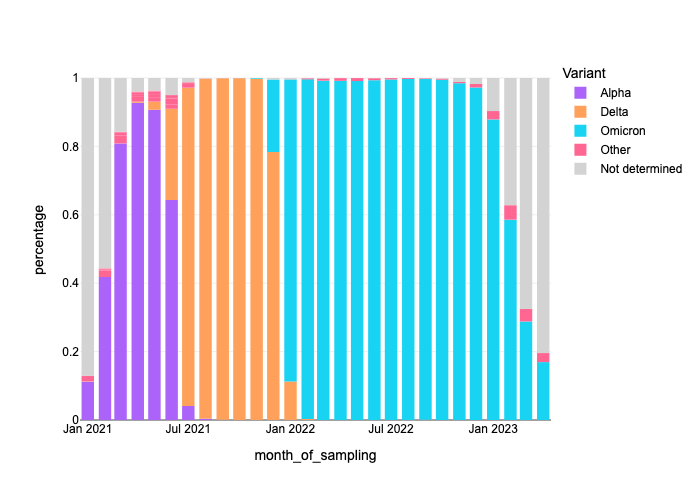

In [33]:
fig = px.bar(variant_count_per_sampling_month_df, x="month_of_sampling", y="percentage", color="clade_who", category_orders={"clade_who": ["Alpha", "Delta", "Omicron", "Other", "Not determined"]}, color_discrete_sequence=px.colors.qualitative.Plotly[3:7] + ["lightgrey"], width=1000, height=600)
fig.update_layout(legend_title_text="Variant", template="presentation", font=dict(
        family="Arial",
        size=12,
        color="black"
    ))
fig.show()

The plot shows percentage distribution of SARS-CoV-2 variants determined by the WHO. It is noticable thatin the beginning lots of sequences without a called variant exist.

During the SARS-CoV-2 pandemic, several variants were mutated from the reference genome originating from Whuan, China. The variants which enforced the most were Alpha (most dominant variant before July 2021), Delta (most dominant variant from July 2021 to Decembre 2021) and Omicron (most dominant variant from January 2021). 

/var/folders/2h/923cq6912sqb0snfvqqfdnmm0000gn/T/ipykernel_9083/1268858872.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



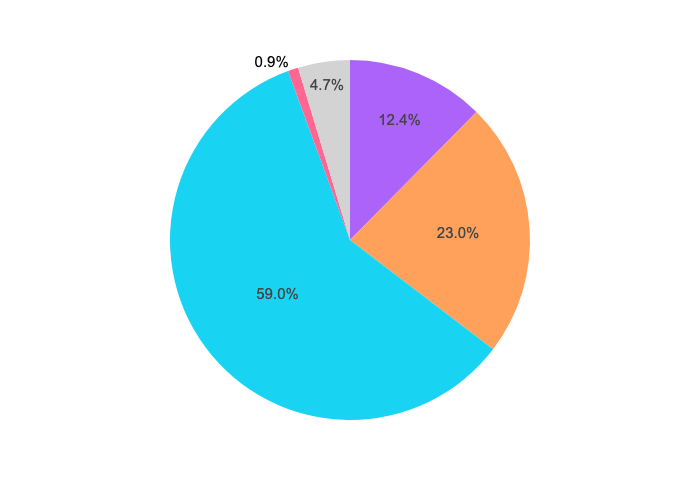

In [34]:
clades_grouped = dataset_df
clades_grouped["clade_who"] = clades_grouped["clade_who"].fillna("Not determined")
clades_grouped = clades_grouped["clade_who"].where(clades_grouped["clade_who"].isin(["Alpha", "Delta", "Omicron", "Not determined"]), "Other")
clade_distribution = clades_grouped.value_counts()
fig = px.pie(clade_distribution, values="count", names=clade_distribution.keys(), color_discrete_sequence=px.colors.qualitative.Plotly[3:7] + ["lightgrey"], category_orders={"clade_who": ["Alpha", "Delta", "Omicron", "Other", "Not determined"]})
fig.update_traces(texttemplate="%{percent:.1%}")
fig.update_layout(showlegend=False,template="presentation", width=500, height=500,
        margin=dict(l=0, r=0),font=dict(
        family="Arial",
        size=15,
        color="black"
    ))
fig.show()

Overall the omicron variant has prevailed the most with 62% of sequences followed by delta (24%) and alpha (13%).

## Geographical distribution within germany

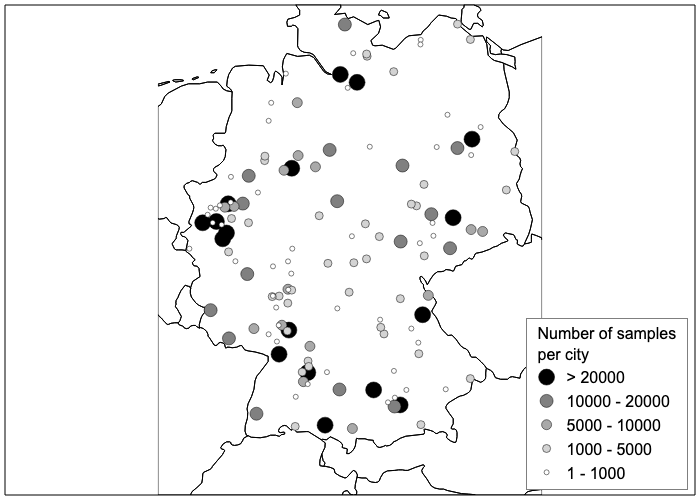

In [103]:
geographical_distribution_df = dataset_df.groupby(["prime_diagnostic_lab.postal_code", "prime_diagnostic_lab.city"]).size().reset_index(name="count")
geographical_distribution_df = geographical_distribution_df.groupby("prime_diagnostic_lab.city", as_index=False).agg({"prime_diagnostic_lab.postal_code":"first", "count":"sum"})
with open("../../data/DE_zip_codes.txt") as zip_codes_file:
    coords = {}
    for line in zip_codes_file:
        values = line.split("\t")
        coords[values[1]] = (values[9], values[10])
geographical_distribution_df["prime_diagnostic_lab.postal_code"] = geographical_distribution_df["prime_diagnostic_lab.postal_code"].apply(
    lambda x: str(f"0{int(x)}") if len(str(int(x))) == 4 else str(int(x)))
geographical_distribution_df["lat"] = geographical_distribution_df["prime_diagnostic_lab.postal_code"].apply(
    lambda x: coords[str(x)][0] if str(x) in coords else None)
geographical_distribution_df["lon"] = geographical_distribution_df["prime_diagnostic_lab.postal_code"].apply(
    lambda x: coords[str(x)][1] if str(x) in coords else None)
geographical_distribution_df["label"] = geographical_distribution_df["prime_diagnostic_lab.city"]  + ", Sequences: " + geographical_distribution_df["count"].astype(str)
limits = [(20000, 100000), (10000, 20000), (5000, 10000), (1000, 5000), (1, 1000)]
scale = [16, 13, 10, 8, 5]
colors = ["black", "grey", "darkgrey", "lightgrey", "white"]
cities = []

fig = go.Figure()
for i in range(len(limits)):
    lim = limits[i]
    mask = (lim[0] < geographical_distribution_df["count"]) & (geographical_distribution_df["count"] < lim[1])
    df_sub = geographical_distribution_df[mask]
    if lim[0] == 20000:
        fig.add_trace(go.Scattergeo(
            lon=df_sub["lon"],
            lat=df_sub["lat"],
            text=df_sub["label"],
            marker=dict(
                size=scale[i],
                color=colors[i],
                line_color="black",
                line_width=0.5,
                sizemode="area"
            ),
            name="> {0}".format(lim[0], lim[1]))
        )
    else:
        fig.add_trace(go.Scattergeo(
            lon=df_sub["lon"],
            lat=df_sub["lat"],
            text=df_sub["label"],
            marker=dict(
                size=scale[i],
                color=colors[i],
                line_color="black",
                line_width=0.5,
                sizemode="area"
            ),
            name="{0} - {1}".format(lim[0], lim[1]))
        )
fig.update_layout(
    width=551,
    height=700,
    paper_bgcolor="White",
    font_color="black",
    geo=dict(
        resolution=50,
        scope="europe",
        showframe=True,
        showcoastlines=True,
        landcolor="white",
        countrycolor="black",
        coastlinecolor="black",
        lakecolor="white",
        projection_type="mercator",
        lonaxis_range=[5.0, 15.0],
        lataxis_range=[47.0, 55.0],
        center={"lat": 50.757958, "lon": 10.266271},
        domain=dict(x=[0, 1], y=[0, 1]),
        bgcolor="white",
    ),
)
fig.update_layout(template="presentation",
                  margin=dict(t=5, b=5, l=5, r=5),
                  font=dict(
        family="Arial",
        size=16,
        color="black"
    ),legend=dict(
        title=dict(text="  Number of samples  <br>  per city      ", font=dict(size=16, family="Arial",),),
        x=0.99,
        y=0.01,
        xanchor="right",
        yanchor="bottom",
        bgcolor="rgba(255,255,255,1.0)",  # Optional: semi-transparent background
        bordercolor="black",
        borderwidth=0.5
    ),
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(
                color="black",
                width=1.0,
            ),
            layer="above"
        )
    ])
fig.show()
fig.write_image("figures/sample_distribution_within_germany.svg",width=551,height=700,)

The sequences contained in the data set are fairly evenly distributed within Germany. Since primary diagnostic labs (instead of sampling labs) are attached, the distibution appears more coarse then one would expect in a pandemic of this extent. Further this means that it is not possible to exactly identify the geographical origin for each sequence.

It is worth to mention that the most dense distribution of sequences is found in northrhine westphalia, which is also the most populated federal state in germany. Especially for metropolises high amounts of sequences are available.

In [101]:
dataset_df["prime_diagnostic_lab.state"].value_counts()


prime_diagnostic_lab.state
North Rhine-West.         302495
Baden-Württemberg         277548
Bavaria                   142815
Saxony                     96909
Schleswig-Holstein         62587
Hamburg                    47987
Rhineland-Palatinate       40895
Lower Saxony               38522
Berlin                     36076
Thuringia                  24375
Brandenburg                24219
Saxony-Anhalt              19008
Saarland                   17557
Hesse                      16721
Mecklenburg-West. Pom.     13375
Bremen                     10398
Name: count, dtype: int64

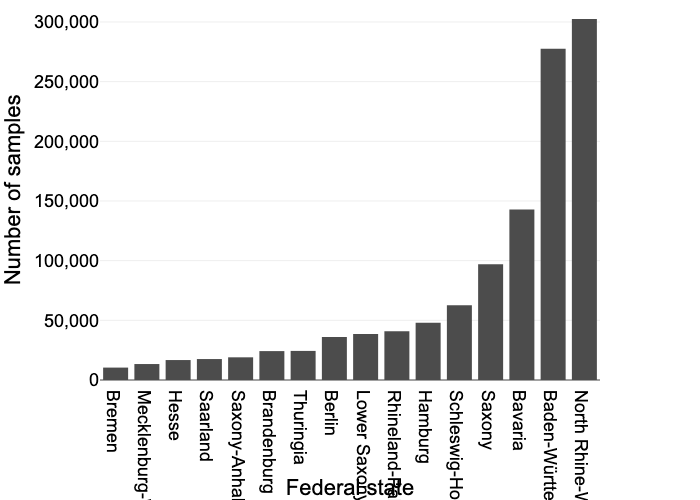

In [102]:
dataset_df.loc[dataset_df["prime_diagnostic_lab.state"] == "Bayern", "prime_diagnostic_lab.state"] = "Bavaria"
dataset_df.loc[dataset_df["prime_diagnostic_lab.state"] == "Hessen", "prime_diagnostic_lab.state"] = "Hesse"
dataset_df.loc[dataset_df["prime_diagnostic_lab.state"] == "Niedersachsen", "prime_diagnostic_lab.state"] = "Lower Saxony"
dataset_df.loc[dataset_df["prime_diagnostic_lab.state"] == "Northrhein-Westfalen", "prime_diagnostic_lab.state"] = "North Rhine-West."
dataset_df.loc[dataset_df["prime_diagnostic_lab.state"] == "Rheinland-Pfalz", "prime_diagnostic_lab.state"] = "Rhineland-Palatinate"
dataset_df.loc[dataset_df["prime_diagnostic_lab.state"] == "Sachsen", "prime_diagnostic_lab.state"] = "Saxony"
dataset_df.loc[dataset_df["prime_diagnostic_lab.state"] == "Sachsen-Anhalt", "prime_diagnostic_lab.state"] = "Saxony-Anhalt"
dataset_df.loc[dataset_df["prime_diagnostic_lab.state"] == "Thüringen", "prime_diagnostic_lab.state"] = "Thuringia"
dataset_df.loc[dataset_df["prime_diagnostic_lab.state"] == "Mecklenburg-Vorpommern", "prime_diagnostic_lab.state"] = "Mecklenburg-West. Pom."

sample_amount_per_state = dataset_df.groupby(["prime_diagnostic_lab.state"]).size().reset_index(name="count").sort_values(by=["count"])
fig = px.bar(sample_amount_per_state, x="prime_diagnostic_lab.state", y="count", color_discrete_sequence=["#4c4c4c"], width=1000, height=600,)
fig.update_yaxes(tickformat=",d")
fig.update_layout(template="presentation", width=1000, height=700, margin=dict(t=0, b=120, l=100, r=100), font=dict(
        family="Arial",
        size=18,
        color="black"
    ), xaxis_title="Federal state",
    yaxis_title="Number of samples")
fig.show()
fig.write_image("figures/samples_per_federal_state.svg",width=1200,height=800,)

In [37]:
print("Cities and counties with the highest amount of sequences")
geographical_distribution_df[geographical_distribution_df["count"] > 20000].sort_values("count", ascending=False)[["prime_diagnostic_lab.city", "count"]]

Cities and counties with the highest amount of sequences


,prime_diagnostic_lab.city,count
65,"Köln, Stadt",70108
36,Heidelberg,64888
43,Karlsruhe,63708
93,"Leverkusen, Stadt",57378
81,Landkreis Nordsachsen,55087
17,"Düsseldorf, Stadt",49042
33,"Hamburg, Freie und Hansestadt",47988
138,Weiden i.d.OPf.,45605
50,Kreis Herzogtum Lauenburg,44676
21,Esslingen,39835


## Distribution of sequencing platforms

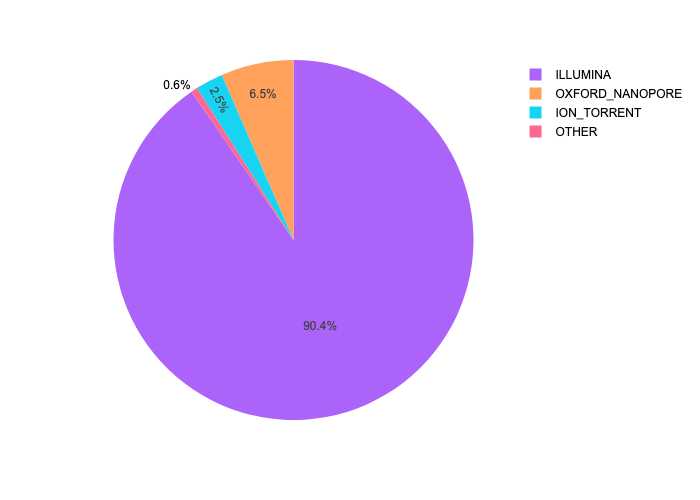

In [38]:
sequencing_platform_distribution = dataset_df["sequencing_platform"].value_counts()
fig = px.pie(sequencing_platform_distribution, values="count", names=sequencing_platform_distribution.keys(), color_discrete_sequence=px.colors.qualitative.Plotly[3:])
fig.update_traces(texttemplate="%{percent:.1%}")

fig.update_layout(template="presentation", width=500, height=500, font=dict(
        family="Arial",
        size=12,
        color="black"
    ))
fig.show()

## Distribution of mutations
Viruses always mutate when a new replica is created. These mutations are caused by errors when copying the viral sequence. Two isolates from a shorter period therefore have fewer mutations than two isolates from a longer period.

The number of different mutations in a dataset will most likely affect the efficiency and performance of the methods used later. When selecting our data, we will therefore first analyse the distribution of mutations in the RKI dataset. We first convert the mutation string to lists.

In [39]:
def get_array_from_string(x):
    return x.apply(lambda mutation_string: mutation_string.split(",") if type(mutation_string) == str else [])
mutations = dataset_df[["substitutions", "insertions", "deletions", "missing", "nonACGTNs"]]
mutations = mutations.apply(lambda x: get_array_from_string(x))
dataset_df[mutations.columns] = mutations[mutations.columns]

/var/folders/2h/923cq6912sqb0snfvqqfdnmm0000gn/T/ipykernel_9083/2641126936.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Clade Clustering

In [40]:
mutation_sampling_month_df = pd.DataFrame()
mutation_sampling_month_df[["medianSubstitutions", "medianInsertions", "medianDeletions", "medianMissing", "medianNonACGTNs"]] = dataset_df.groupby(["month_of_sampling"])[["totalSubstitutions", "totalInsertions", "totalDeletions", "totalMissing", "totalNonACGTNs"]].median()
mutation_sampling_month_df.rename(columns={"totalSubstitutions": "medianSubstitutions", "totalInsertions": "medianInsertions", "meanDeletions": "medianDeletions", "totalMissing": "medianMissing", "totalNonACGTNs": "medianNonACGTNs"})
mutation_sampling_month_df[["totalSubstitutions", "totalInsertions", "totalDeletions", "totalMissing", "totalNonACGTNs"]] = dataset_df.groupby(["month_of_sampling"])[["totalSubstitutions", "totalInsertions", "totalDeletions", "totalMissing", "totalNonACGTNs"]].sum()
mutation_sampling_month_df["totalMutations"] = mutation_sampling_month_df["totalSubstitutions"] + mutation_sampling_month_df["totalInsertions"] + mutation_sampling_month_df["totalDeletions"]

mutation_sampling_month_df["clade"] = dataset_df["clade"]

### Distribution of substitutions

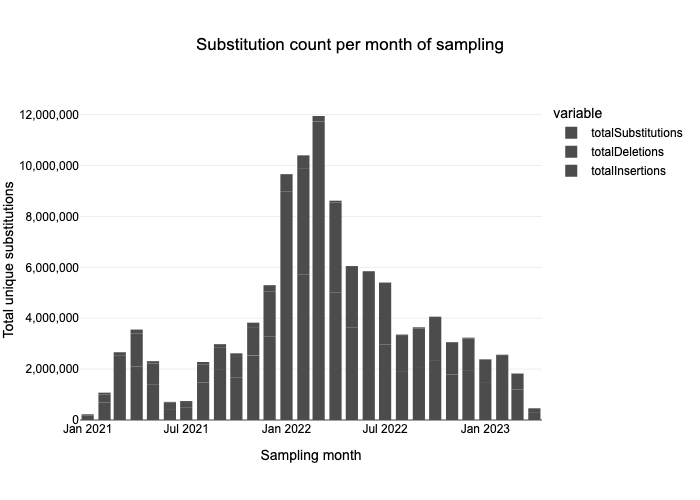

In [41]:
fig = px.bar(mutation_sampling_month_df, y=["totalSubstitutions", "totalDeletions", "totalInsertions"], title="Substitution count per month of sampling", color_discrete_sequence=["#4c4c4c"], width=1000, height=600)
fig.update_yaxes(tickformat=",d")
fig.update_layout(template="presentation", font=dict(
        family="Arial",
        size=12,
        color="black"
    ), xaxis_title="Sampling month",
    yaxis_title="Total unique substitutions")
fig.show()

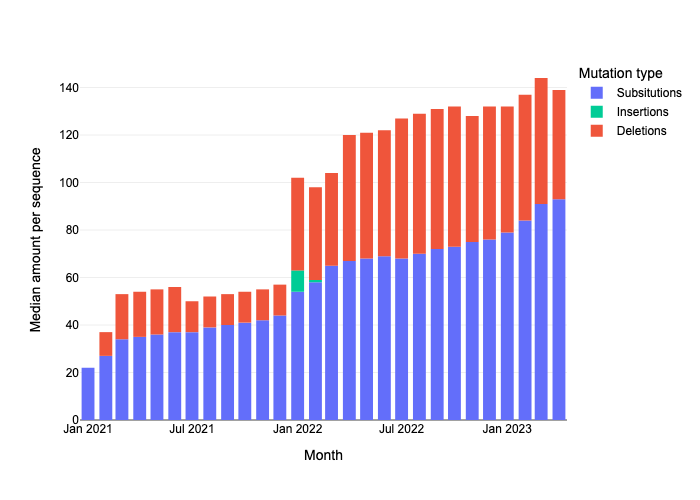

In [105]:
fig = px.bar(mutation_sampling_month_df, y=["medianSubstitutions", "medianInsertions", "medianDeletions"],  color_discrete_sequence=[px.colors.qualitative.Plotly[0], px.colors.qualitative.Plotly[2], px.colors.qualitative.Plotly[1]], width=1000, height=600)
fig.update_yaxes(tickformat=",d")
fig.for_each_trace(lambda t: t.update(name=t.name.replace("medianSubstitutions", "Subsitutions")))
fig.for_each_trace(lambda t: t.update(name=t.name.replace("medianInsertions", "Insertions")))
fig.for_each_trace(lambda t: t.update(name=t.name.replace("medianDeletions", "Deletions")))

fig.update_layout(legend_title_text="Mutation type", template="presentation", font=dict(
        family="Arial",
        size=12,
        color="black"
    ), xaxis_title="Month",
    yaxis_title="Median amount per sequence")
fig.show()
fig.write_image("figures/median_amount_of_mutations_per_sequence_per_month.svg")

In [43]:
mutation_sampling_state_df = pd.DataFrame()
mutation_sampling_state_df[["medianSubstitutions", "medianInsertions", "medianDeletions", "medianMissing", "medianNonACGTNs"]] = dataset_df.groupby(["prime_diagnostic_lab.state"])[["totalSubstitutions", "totalInsertions", "totalDeletions", "totalMissing", "totalNonACGTNs"]].median()
mutation_sampling_state_df.rename(columns={"totalSubstitutions": "medianSubstitutions", "totalInsertions": "medianInsertions", "meanDeletions": "medianDeletions", "totalMissing": "medianMissing", "totalNonACGTNs": "medianNonACGTNs"})
mutation_sampling_state_df[["totalSubstitutions", "totalInsertions", "totalDeletions", "totalMissing", "totalNonACGTNs"]] = dataset_df.groupby(["prime_diagnostic_lab.state"])[["totalSubstitutions", "totalInsertions", "totalDeletions", "totalMissing", "totalNonACGTNs"]].sum()
mutation_sampling_state_df["totalMutations"] = mutation_sampling_month_df["totalSubstitutions"] + mutation_sampling_month_df["totalInsertions"] + mutation_sampling_month_df["totalDeletions"]

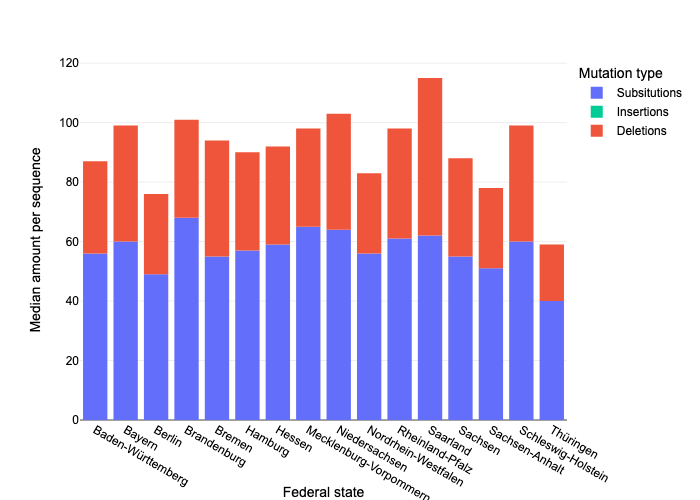

In [104]:
fig = px.bar(mutation_sampling_state_df, y=["medianSubstitutions", "medianInsertions", "medianDeletions"],  color_discrete_sequence=[px.colors.qualitative.Plotly[0], px.colors.qualitative.Plotly[2], px.colors.qualitative.Plotly[1]], width=1000, height=600)
fig.update_yaxes(tickformat=",d")
fig.for_each_trace(lambda t: t.update(name=t.name.replace("medianSubstitutions", "Subsitutions")))
fig.for_each_trace(lambda t: t.update(name=t.name.replace("medianInsertions", "Insertions")))
fig.for_each_trace(lambda t: t.update(name=t.name.replace("medianDeletions", "Deletions")))

fig.update_layout(legend_title_text="Mutation type", template="presentation", font=dict(
        family="Arial",
        size=12,
        color="black"
    ), xaxis_title="Federal state",
    yaxis_title="Median amount per sequence")
fig.show()


In [45]:
dataset_df = dataset_df[dataset_df["totalSubstitutions"] < 300]

In [46]:
len(dataset_df)

1180629

1.180.629 sequences remain.